In [1]:
import cv2
import numpy as np
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import os
import time

In [2]:
class AegisRedactor:
    def __init__(self):
        """Initialize the MTCNN detector once to save overhead."""
        print("Initializing MTCNN Detector...")
        self.detector = MTCNN()

    def load_image(self, image_path):
        """Loads an image and converts it to RGB for MTCNN/Matplotlib."""
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not load image at {image_path}")
        return img

    def get_detections(self, image):
        """Performs face detection and returns bounding boxes."""
        # MTCNN needs RGB
        rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        detections = self.detector.detect_faces(rgb_img)
        return [d['box'] for d in detections]

    def plot_preview(self, image, boxes):
        """Displays the image with ID labels using Matplotlib."""
        display_img = image.copy()
        display_img = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)
        
        for i, (x, y, w, h) in enumerate(boxes):
            cv2.rectangle(display_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            label = f"ID: {i}"
            cv2.putText(display_img, label, (x, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        plt.figure(figsize=(12, 8))
        plt.imshow(display_img)
        plt.title(f"Detected {len(boxes)} faces")
        plt.axis('off')
        plt.show()

    def apply_redaction(self, image, boxes, indices_to_blur):
        """Applies Gaussian blur to selected bounding boxes."""
        final_img = image.copy()
        for idx in indices_to_blur:
            if 0 <= idx < len(boxes):
                x, y, w, h = boxes[idx]
                x, y = max(0, x), max(0, y)
                
                roi = final_img[y:y+h, x:x+w]
                if roi.size > 0:
                    # Adaptive kernel size: roughly half the face width, must be odd
                    ksize = (int(w//2) | 1, int(h//2) | 1)
                    ksize = (max(31, ksize[0]), max(31, ksize[1]))
                    
                    blurred_roi = cv2.GaussianBlur(roi, ksize, 30)
                    final_img[y:y+h, x:x+w] = blurred_roi
            else:
                print(f"Warning: ID {idx} is out of range.")
        return final_img

    def show_result(self, image):
        """Displays the final redacted image."""
        result_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 8))
        plt.imshow(result_rgb)
        plt.title("Redaction Result")
        plt.axis('off')
        plt.show()

    def save_image(self, image, filename, folder_path="assets/savedImages"):
        """Saves the processed image to the specified folder."""
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Created directory: {folder_path}")
        
        full_path = os.path.join(folder_path, filename)
        success = cv2.imwrite(full_path, image)
        
        if success:
            print(f"Successfully saved image to: {full_path}")
        else:
            print(f"Failed to save image to: {full_path}")
        return full_path




In [3]:
redactor = AegisRedactor()

Initializing MTCNN Detector...


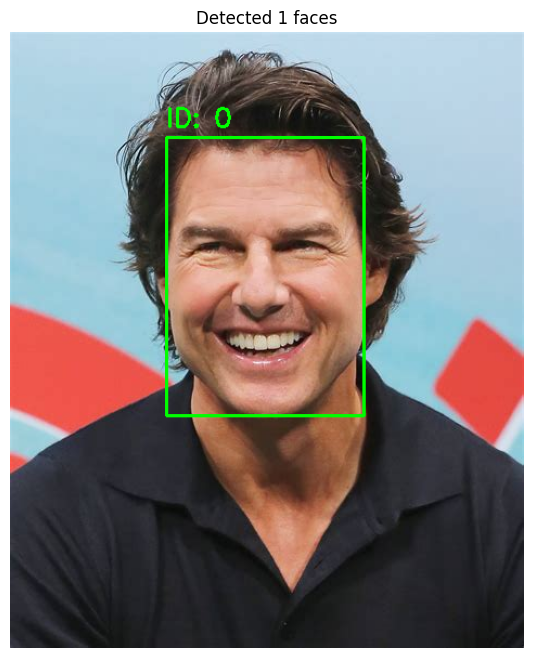

In [5]:
img = redactor.load_image('assets/samples/face4.jpg')
boxes = redactor.get_detections(img)
redactor.plot_preview(img, boxes)

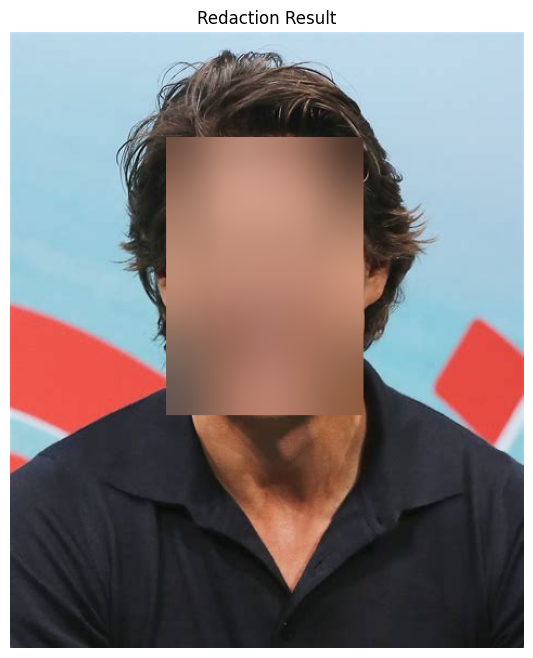

In [6]:
# to_blur = [1,2,3,4] 
# to_blur=list(range(1,len(boxes)))
to_blur=[0]
result = redactor.apply_redaction(img, boxes, to_blur)
redactor.show_result(result)

In [19]:
redactor.save_image(result, f"blur_face_{int(1e7*(time.time()-int(time.time())))}.png")

Successfully saved image to: assets/savedImages\blur_face_9038512.png


'assets/savedImages\\blur_face_9038512.png'